## Problem Statement

The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. 

Hate Speech Detection is generally a task of sentiment classification. So for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, the Twitter tweets were used to identify tweets containing  Hate speech.

## Task
- Problem Understanding
- Data Cleaning and Normalisation
- Representation Learning
- Model Building & Training
- Performance Evaluation & Reporting
- Model Deployment
- Model Inference
 

## Data Attributes
label : 0 or 1   
text_format : original tweets with noise

### Data Cleaning

In [149]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import random
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
from wordcloud import WordCloud

from datasets import load_metric
from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from transformers import AutoTokenizer, pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

In [151]:
df = pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [152]:
df.loc[1, 'tweet']

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

In [153]:
#remove hash tag # and @
df['tweet'] = df.tweet.str.replace('#', '')
df.loc[1,'tweet'] 

"@user @user thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx.    disapointed getthanked"

In [154]:
#remove username
df['tweet'] = df['tweet'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
df['tweet']

0          when a father is dysfunctional and is so sel...
1          thanks for lyft credit i cant use cause they...
2                                      bihday your majesty
3        model   i love u take with u all the time in u...
4                     factsguide society now    motivation
                               ...                        
31957                                 ate  isz that youuu 
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960     sikh temple vandalised in in calgary wso cond...
31961                          thank you  for you follow  
Name: tweet, Length: 31962, dtype: object

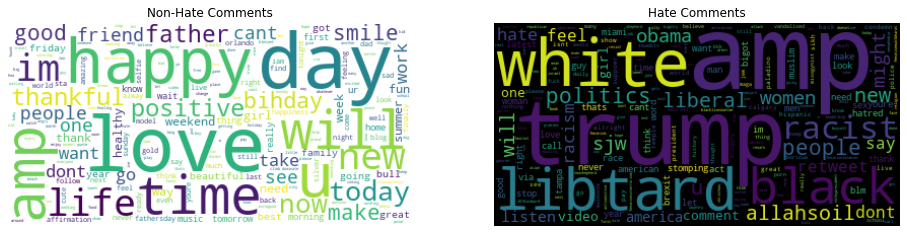

In [155]:
#check words
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(df['tweet'][df.label == 0])
text_neg = " ".join(df['tweet'][df.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [156]:
#check data balance
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [157]:
#resampleing the data
train_majority = df[df.label==0]
train_minority = df[df.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
df_upsampled = pd.concat([train_minority_upsampled, train_majority])
df_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

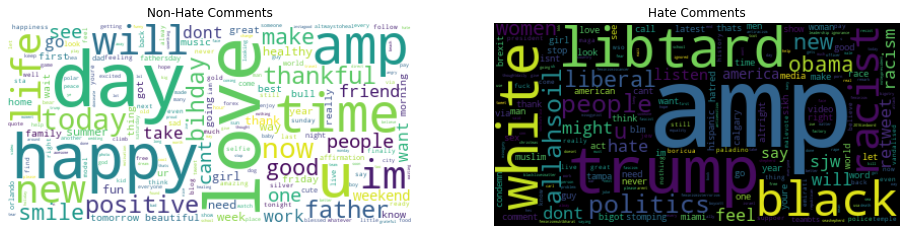

In [158]:
#check words again
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(df_upsampled['tweet'][df_upsampled.label == 0])
text_neg = " ".join(df_upsampled['tweet'][df_upsampled.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

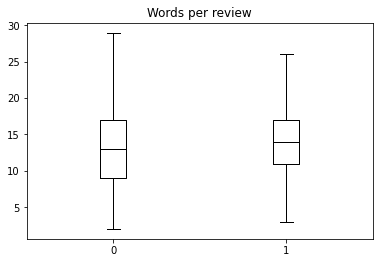

In [39]:
#check words in each review
df_upsampled["Words per review"] = df_upsampled["tweet"].str.split().apply(len)
df_upsampled.boxplot("Words per review", by="label", grid=False, showfliers=False,color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Not too many words, keep all of them and padding

In [40]:
#train, test, validation split
train, test = train_test_split(df_upsampled, test_size=0.2, random_state=157)
train, val = train_test_split(train, test_size=0.25, random_state=157)

train.shape, test.shape, val.shape

((35664, 4), (11888, 4), (11888, 4))

In [41]:
train_dict = Dataset.from_pandas(train[['label', 'tweet']])
test_dict = Dataset.from_pandas(test[['label', 'tweet']])
val_dict = Dataset.from_pandas(val[['label', 'tweet']])

ds = DatasetDict()
ds['train'] = train_dict
ds['test'] = test_dict
ds['val'] = val_dict

ds

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', '__index_level_0__'],
        num_rows: 35664
    })
    test: Dataset({
        features: ['label', 'tweet', '__index_level_0__'],
        num_rows: 11888
    })
    val: Dataset({
        features: ['label', 'tweet', '__index_level_0__'],
        num_rows: 11888
    })
})

In [42]:
#tokenization

checkpoint = "bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["tweet"], padding=True, truncation=True)

ds_encoded = ds.map(tokenize_function, batched=True, batch_size=None)
ds_encoded

Parameter 'function'=<function tokenize_function at 0x7fee53985820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35664
    })
    test: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11888
    })
    val: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11888
    })
})

### Representation Learning

In [43]:
sub_ds = DatasetDict()

sub_ds['train'] = ds_encoded['train'].shuffle(seed=1).select(range(60))
sub_ds['val'] = ds_encoded['val'].shuffle(seed=1).select(range(20))
sub_ds['test'] = ds_encoded['test'].shuffle(seed=1).select(range(20))

sub_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60
    })
    val: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20
    })
    test: Dataset({
        features: ['label', 'tweet', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20
    })
})

In [44]:
model_name = f"{checkpoint}-finetuned-subset"

def training_args(epochs, learning_rate, batch_size):
    logging_steps = len(sub_ds["train"]) // batch_size
    return TrainingArguments(output_dir = model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  )

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [46]:
#computing acc in trainer
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [22]:
#default setting
torch.cuda.empty_cache()

trainer = Trainer(model=model, 
                  args=training_args(epochs=3, learning_rate=5e-5, batch_size=8), 
                  train_dataset=sub_ds["train"],
                  eval_dataset=sub_ds["val"],
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics)

default_result = trainer.train()
default_result

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 60
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683400,0.653699,0.550000
2,0.569400,0.482377,0.800000
3,0.349400,0.452403,0.800000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=24, training_loss=0.5109533667564392, metrics={'train_runtime': 272.6214, 'train_samples_per_second': 0.66, 'train_steps_per_second': 0.088, 'total_flos': 15354996746400.0, 'train_loss': 0.5109533667564392, 'epoch': 3.0})

In [23]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


{'eval_loss': 0.45240265130996704,
 'eval_accuracy': 0.8,
 'eval_runtime': 4.0185,
 'eval_samples_per_second': 4.977,
 'eval_steps_per_second': 0.747,
 'epoch': 3.0}

In [37]:
torch.cuda.empty_cache()

#try the different learning rate with batch size 8 and 3 epochs
rate_list = [4e-5, 2e-5, 2e-5, 1e-5]
trainer_list = []
for rate in rate_list:
    trainer = Trainer(model=model, 
                  args=training_args(epochs=3, learning_rate=rate, batch_size=8), 
                  train_dataset=sub_ds["train"],
                  eval_dataset=sub_ds["val"],
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics)
    trainer_list.append(trainer)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from al

In [39]:
for trainer in trainer_list:
    lr_result = trainer.train()
    print(lr_result)

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 60
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Epoch,Training Loss,Validation Loss,Accuracy
1,0.674800,0.655103,0.600000
2,0.591100,0.538775,0.850000
3,0.465900,0.484448,0.850000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=24, training_loss=0.5494327247142792, metrics={'train_runtime': 286.3232, 'train_samples_per_second': 0.629, 'train_steps_per_second': 0.084, 'total_flos': 15354996746400.0, 'train_loss': 0.5494327247142792, 'epoch': 3.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.282800,0.399908,0.850000
2,0.155000,0.349580,0.800000
3,0.078400,0.361019,0.850000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=24, training_loss=0.1612645797431469, metrics={'train_runtime': 386.7909, 'train_samples_per_second': 0.465, 'train_steps_per_second': 0.062, 'total_flos': 15354996746400.0, 'train_loss': 0.1612645797431469, 'epoch': 3.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.058000,0.461363,0.850000
2,0.027900,0.447971,0.850000
3,0.015700,0.465674,0.850000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=24, training_loss=0.03131659266849359, metrics={'train_runtime': 336.1702, 'train_samples_per_second': 0.535, 'train_steps_per_second': 0.071, 'total_flos': 15354996746400.0, 'train_loss': 0.03131659266849359, 'epoch': 3.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.011500,0.613094,0.850000
2,0.006200,0.636686,0.850000
3,0.005000,0.639272,0.850000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=24, training_loss=0.007130741374567151, metrics={'train_runtime': 303.3538, 'train_samples_per_second': 0.593, 'train_steps_per_second': 0.079, 'total_flos': 15354996746400.0, 'train_loss': 0.007130741374567151, 'epoch': 3.0})


save results in csv for better ploting

In [91]:
lr = pd.read_csv('LearningRates.csv')
lr.head()

,Epoch,Loss,Type,Accuracy,LearningRate
0,1,0.0115,Training,0.85,0.00001
1,2,0.0062,Training,0.85,0.00001
2,3,0.0050,Training,0.85,0.00001
3,1,0.0580,Training,0.85,0.00002
4,2,0.0279,Training,0.85,0.00002


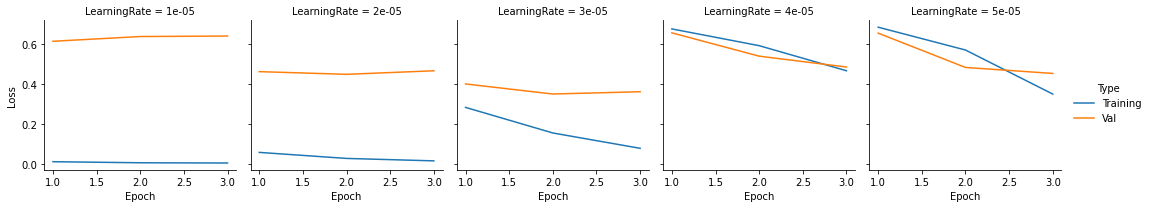

In [92]:
g = sns.FacetGrid(lr, col = 'LearningRate', hue = 'Type', sharex=True, sharey=True, legend_out=True)
g = g.map(plt.plot, 'Epoch','Loss', label = 'Training')
g.add_legend()

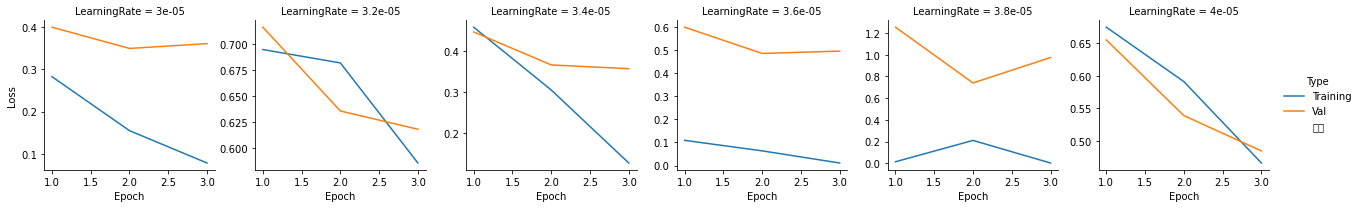

In [94]:
lr2 = pd.read_csv('LearningRates2.csv')

g = sns.FacetGrid(lr2, col = 'LearningRate', hue = 'Type', sharex=True, sharey=False, legend_out=True)
g = g.map(plt.plot, 'Epoch','Loss', label = 'Training')
g.add_legend()

In [95]:
#check learning rate 3.4e-5

torch.cuda.empty_cache()

epoch_list = [2, 6, 10, 15, 20]
trainer_list = []
for epoch in epoch_list:
    trainer = Trainer(model=model, 
                  args=training_args(epochs=epoch, learning_rate=3.4e-5, batch_size=8), 
                  train_dataset=sub_ds["train"],
                  eval_dataset=sub_ds["val"],
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics)
    trainer_list.append(trainer)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from al

In [96]:
trainer_list

In [97]:
epoch_results = []
for trainer in trainer_list:
    epoch_result = trainer.train()
    print(epoch_result)
    epoch_results.append(epoch_result)

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 60
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.538866,0.900000
2,0.000000,1.544522,0.900000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __

TrainOutput(global_step=16, training_loss=3.166496398421259e-07, metrics={'train_runtime': 322.593, 'train_samples_per_second': 0.372, 'train_steps_per_second': 0.05, 'total_flos': 10236664497600.0, 'train_loss': 3.166496398421259e-07, 'epoch': 2.0})


  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.562273,0.900000
2,0.000000,1.580441,0.900000
3,0.000000,1.594656,0.900000
4,0.000000,1.604622,0.900000
5,0.000000,1.610414,0.900000
6,0.000000,1.612413,0.900000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=48, training_loss=2.0768491400720754e-07, metrics={'train_runtime': 803.8069, 'train_samples_per_second': 0.448, 'train_steps_per_second': 0.06, 'total_flos': 30709993492800.0, 'train_loss': 2.0768491400720754e-07, 'epoch': 6.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.625081,0.900000
2,0.000000,1.640169,0.900000
3,0.000000,1.654620,0.900000
4,0.000000,1.667428,0.900000
5,0.000000,1.678468,0.900000
6,0.000000,1.687111,0.900000
7,0.000000,1.693320,0.900000
8,0.000000,1.697312,0.900000
9,0.000000,1.699713,0.900000
10,0.000000,1.700636,0.900000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=80, training_loss=1.0300426840359478e-07, metrics={'train_runtime': 852.5552, 'train_samples_per_second': 0.704, 'train_steps_per_second': 0.094, 'total_flos': 51183322488000.0, 'train_loss': 1.0300426840359478e-07, 'epoch': 10.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.708278,0.900000
2,0.000000,1.718277,0.900000
3,0.000000,1.728829,0.900000
4,0.000000,1.737312,0.900000
5,0.000000,1.744367,0.900000
6,0.000000,1.750785,0.900000
7,0.000000,1.755884,0.900000
8,0.000000,1.759849,0.900000
9,0.000000,1.763695,0.900000
10,0.000000,1.767423,0.900000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=120, training_loss=1.887480251353916e-08, metrics={'train_runtime': 1693.6945, 'train_samples_per_second': 0.531, 'train_steps_per_second': 0.071, 'total_flos': 76774983732000.0, 'train_loss': 1.887480251353916e-08, 'epoch': 15.0})


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,1.777088,0.900000
2,0.000000,1.780812,0.900000
3,0.000000,1.784919,0.900000
4,0.000000,1.789389,0.900000
5,0.000000,1.794125,0.900000
6,0.000000,1.798303,0.900000
7,0.000000,1.802403,0.900000
8,0.000000,1.805814,0.900000
9,0.000000,1.808884,0.900000
10,0.000000,1.811708,0.900000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you ca

TrainOutput(global_step=160, training_loss=1.2107192692845103e-09, metrics={'train_runtime': 1682.3929, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.095, 'total_flos': 102366644976000.0, 'train_loss': 1.2107192692845103e-09, 'epoch': 20.0})


In [110]:
loss = []
epoch_num = []

for i in range(5):
    target = epoch_results[i]
    loss.append(target.training_loss)
    epoch_num.append(target.metrics['epoch'])

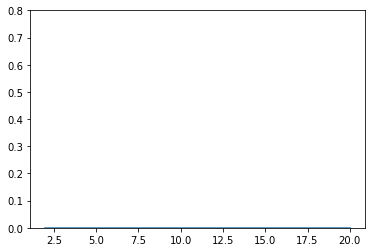

In [117]:
plt.plot(epoch_num, loss)
plt.ylim(0,0.8)
plt.show()

almost zero, no need that much epochs, use 2 instead

### Model Building and Training

In [118]:
#check full model
model_name = f"{checkpoint}-finetuned-subset"

def training_args2(epochs, learning_rate, batch_size):
    logging_steps = len(ds_encoded["train"]) // batch_size
    return TrainingArguments(output_dir = model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model2 = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /Users/apple/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/r

In [119]:
torch.cuda.empty_cache()


trainer = Trainer(model=model, 
                  args=training_args(epochs=2, learning_rate=3.4e-5, batch_size=32), 
                  train_dataset=ds_encoded['train'],
                  eval_dataset=ds_encoded["val"],
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [120]:
full_result = trainer.train()
full_result

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tweet, __index_level_0__. If tweet, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 35664
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2230


Epoch,Training Loss,Validation Loss,Accuracy
1,0.002300,0.042785,0.990158
2,0.000100,0.049327,0.991841


Saving model checkpoint to bert-base-cased-finetuned-subset/checkpoint-500
Configuration saved in bert-base-cased-finetuned-subset/checkpoint-500/config.json
Model weights saved in bert-base-cased-finetuned-subset/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-cased-finetuned-subset/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-cased-finetuned-subset/checkpoint-500/special_tokens_map.json
Saving model checkpoint to bert-base-cased-finetuned-subset/checkpoint-1000
Configuration saved in bert-base-cased-finetuned-subset/checkpoint-1000/config.json
Model weights saved in bert-base-cased-finetuned-subset/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bert-base-cased-finetuned-subset/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bert-base-cased-finetuned-subset/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequen

TrainOutput(global_step=2230, training_loss=0.08336774118009826, metrics={'train_runtime': 138171.2146, 'train_samples_per_second': 0.516, 'train_steps_per_second': 0.016, 'total_flos': 6084673377373440.0, 'train_loss': 0.08336774118009826, 'epoch': 2.0})

In [123]:
trainer.save_model()

Saving model checkpoint to bert-base-cased-finetuned-subset
Configuration saved in bert-base-cased-finetuned-subset/config.json
Model weights saved in bert-base-cased-finetuned-subset/pytorch_model.bin
tokenizer config file saved in bert-base-cased-finetuned-subset/tokenizer_config.json
Special tokens file saved in bert-base-cased-finetuned-subset/special_tokens_map.json


In [124]:
model_name

'bert-base-cased-finetuned-subset'

### Model Inference

In [125]:
test_data = pd.read_csv('test_tweets.csv')
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [129]:
classifier = pipeline('text-classification', model=model_name)

loading configuration file bert-base-cased-finetuned-subset/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased-finetuned-subset",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading configuration file bert-base-cased-finetuned-subset/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased-finetuned-subset",
  "archi

In [138]:
def hate_detection():
    num = random.randint(0,len(test_data))
    text = test_data.tweet[num]
    print(text, classifier(text))

In [140]:
hate_detection()

i am thankful for now. #thankful #positive      [{'label': 'LABEL_0', 'score': 0.9999995231628418}]


In [141]:
hate_detection()

at 11:41 on 6/17/16 i, bismark joseph mora, finished watching all 74 episodes of jersey shore   [{'label': 'LABEL_0', 'score': 0.9999994039535522}]


In [145]:
hate_detection()

prison is big business in #america. no wonder its justice system is corruptly too quick to prosecute.   @user  [{'label': 'LABEL_0', 'score': 0.9997380375862122}]
